# Arabic Image Captioning
This Notebook Illustrates Our contribution in image captioning but in the Arabic language. the aim of this project firstly contributes to enhancing the resources for the Arabic language in NLP problems and secondly to use this project to help Arabic visually impaired people. So we hope the community help us improve that to provide a 
 good quality free service for those people because they need it. 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Install tensorflow_hub and load the multilangual embeddings 


In [1]:
!pip3 install tensorflow_text>=2.0.0rc0
import tensorflow_hub as hub
import tensorflow_text
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")


In [3]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import csv
import sys
import base64
import nltk
from keras.utils import to_categorical


## 2. Download and Prepare Dataset 
We used MS-COCO Captioning dataset, We translate captions using Google translator and it works a little bit fine, but by the way captions need a lot of improvement. 
  

In [4]:
# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder


13510574080/13510573713 [==============================] - 360s 0us/step


In [5]:
# Download image files
image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/val2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

6645014528/6645013297 [==============================] - 184s 0us/step


In [ ]:
!rsync -vau --remove-source-files /content/val2014 /content/train2014

In [ ]:
#!unzip '/content/drive/My Drive/data/train2014.zip'

In [7]:
#To load excel file into a dataframe 
import pandas as pd 
train_data = pd.read_excel('/content/drive/My Drive/caption/Caption_Evaluation_model_and_data/karpathy_arabic_data_train.xlsx')
val_data = pd.read_excel('/content/drive/My Drive/caption/Caption_Evaluation_model_and_data/karpathy_arabic_data_val.xlsx')
PATH_train = '/content/train2014/'
PATH_val = '/content/val2014/'
# Store captions and image names in vectors
captions_train = []
img_name_vector_train = []
captions_val = []
img_name_vector_val = []
#add path of images with its image_id and add <start>, <end> to captions for RNN purposes 
for annot in train_data["caption"]:
  cap = '<start> ' + annot +' <end>'
  captions_train.append(cap)
for annot in val_data["caption"]:
  cap = '<start> ' + annot +' <end>'
  captions_val.append(cap)

for i, annot_id in enumerate(train_data["im_names"]):
  if (train_data["splits"][i]=='restval'):
    image_path = PATH_val + annot_id
    img_name_vector_train.append(image_path)
  else:
    image_path = PATH_train + annot_id
    img_name_vector_train.append(image_path)


for annot_id in val_data["im_names"]:
    image_path = PATH_val + annot_id
    img_name_vector_val.append(image_path)

In [8]:
print(len(img_name_vector_train[-1]))
print(len(img_name_vector_val[-1]))
print(img_name_vector_train[-1][18:])
print(img_name_vector_val[-1][16:])

50
46
/COCO_train2014_000000475546.jpg
/COCO_val2014_000000296759.jpg


### Clean Captions
1. Remove diacritics,
2. normalize some charecters like converting `ة` to `ه` and `ي` to `ى` 
3. Remove punctuations
4. Remove mention

In [10]:
import arabic_preprocessing 


In [11]:
from tqdm import tqdm 
from arabic_preprocessing import Arabic_preprocessing
process_arab = Arabic_preprocessing()
pro_captions_train = []
pro_captions_val = []


for capp in tqdm(captions_train):
  text = process_arab.preprocess_arabic_text(capp)
  pro_captions_train.append(text)

for capp in tqdm(captions_val):
  text = process_arab.preprocess_arabic_text(capp)
  pro_captions_val.append(text) 


100%|██████████| 25010/25010 [00:00<00:00, 39972.85it/s]


In [12]:
print('before >> ',captions_train[10000])
print('after >> ',pro_captions_train[10000])

before >>  <start> ['الرجال يركبون ألواح التزلج الخاصة بهم في الخارج معًا.'] <end>
after >>  الرجال يركبون الواح التزلج الخاصه بهم في الخارج معا


In [13]:
last_captions_train = []
last_captions_val = []
for annot in pro_captions_train:
  cap = '<start> ' + annot +' <end>'
  last_captions_train.append(cap)
for annot in pro_captions_val:
  cap = '<start> ' + annot +' <end>'
  last_captions_val.append(cap)


In [14]:
last_captions_train[0]

'<start> امراه ترتدي شبكه علي راسها تقطع كعكه <end>'

## 3. Choose Image model To extract features from images 
- We have to choose which image model we need to work with and we have here three options:
1. Using ResNet101 model pretrained on imagenet 
2. Using Vgg19 model pretrained on imagenet 
3. Using InceptionV3 model pretrained on imagenet 

**Note**:
If you choosed option 1 or 3 and you are using google colab ou will encounter storage issue and to solve that use vgg19 as it's features dimention less than other two.

**Please**: Run only the cells for the model you will use 


### Using RestNet101 Model

In [ ]:
image_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

171450368/171446536 [==============================] - 4s 0us/step


In [ ]:
#if you want to save to drive make image_path to be image_path[0],image_path[1]
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, image_path

### Using Vgg19 Model

In [15]:
image_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

80142336/80134624 [==============================] - 2s 0us/step


In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path

### Using Inception Model

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
#if you want to save to drive make image_path to be image_path[0],image_path[1]
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
'''
last_names = []
encode_train1 = sorted(set(img_name_vector))
encode_train2 = sorted(set(features_image_path_vec))
for x,y in zip(encode_train1,encode_train2):
  z = [x,y]
  last_names.append(z)
'''

In [18]:
#Know the shape of feature vector 
img,image_path= load_image(img_name_vector_train[0])
img =np.expand_dims(img, axis=0)
img_tensor_val = image_features_extract_model(img)
np.shape(img_tensor_val)

TensorShape([1, 7, 7, 512])

### Extract image features 

In [20]:
os.mkdir("features")

In [22]:
# Get unique images
from tqdm import tqdm
encode_train = sorted(set(img_name_vector_train))
train1 = encode_train[60000:]
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    if len(path_of_feature) == 50:
      np.save('/content/features'+path_of_feature[18:], bf.numpy())
      os.remove(path_of_feature)
    else:
      np.save('/content/features'+path_of_feature[16:], bf.numpy())
      os.remove(path_of_feature)


100%|██████████| 1771/1771 [09:43<00:00,  3.04it/s]


In [23]:
!rm -rf '/content/train2014'

In [ ]:
'''
for im in encode_train[60000:]:
  os.remove(im)
  '''

### Extract text feaures
1. Tekonize captions 
2. Generate Dictionary 
3. Convert words to numerated sequences to deal with ML models 

In [26]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

#### Training sequences 

In [27]:
# Choose the top 10000 words from the vocabulary
top_k = 30000  # common size is 30000 to 50000
#we make one hot encoding (vector with a length = dictionary length) for the words from the dictionary 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions_train)
train_seqs = tokenizer.texts_to_sequences(captions_train)

#word_index is the dictionary or vocaulary of words 
word_index = tokenizer.word_index
index_word = tokenizer.index_word
print('Found %s unique tokens.' % len(word_index))

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(captions_train)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',truncating='post',maxlen=15)


# Calculates the max_length, which is used to store the attention weights
#max_length = calc_max_length(train_seqs)



Found 74909 unique tokens.


#### Validation sequences 

In [28]:
# Choose the top 10000 words from the vocabulary
top_k = 30000  # common size is 30000 to 50000
#we make one hot encoding (vector with a length = dictionary length) for the words from the dictionary 
tokenizer_val = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer_val.fit_on_texts(captions_val)
train_seqs_val = tokenizer_val.texts_to_sequences(captions_val)

#word_index is the dictionary or vocaulary of words 
word_index_val = tokenizer_val.word_index
index_word_val = tokenizer_val.index_word
print('Found %s unique tokens.' % len(word_index_val))

tokenizer_val.word_index['<pad>'] = 0
tokenizer_val.index_word[0] = '<pad>'


# Create the tokenized vectors
train_seqs_val = tokenizer_val.texts_to_sequences(captions_val)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector_val = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',truncating='post',maxlen=15)


# Calculates the max_length, which is used to store the attention weights
#max_length = calc_max_length(train_seqs)



Found 17012 unique tokens.


In [ ]:
# Uncomment this if you want to save your dictionary and sequences to use it as is in future training  
'''
with open('/content/drive/My Drive/caption/Caption_Evaluation_model_and_data/word_index.pkl', 'wb') as f:
  pickle.dump(word_index, f)
with open('/content/drive/My Drive/Caption_Evaluation_model_and_data/index_word.pkl', 'wb') as f:
  pickle.dump(index_word, f) 
with open('/content/drive/My Drive/Caption_Evaluation_model_and_data/cap_vector.pkl', 'wb') as f:
  pickle.dump(cap_vector, f)
'''

In [ ]:
# uncomment this if yyou want to load your saved dictionaries and emedding matrix 
'''
with open('/content/drive/My Drive/embedding_matrix_60k.pkl',"rb") as f:
  embedding_matrix = pickle.load(f)

with open('/content/drive/My Drive/word_index_60k.pkl',"rb") as f:
  word_index = pickle.load(f)

with open('/content/drive/My Drive/index_word_60k.pkl',"rb") as f:
  index_word = pickle.load(f)

with open('/content/drive/My Drive/cap_vector60k.pkl',"rb") as f:
  cap_vector = pickle.load(f)
'''

In [31]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector_train,
                                                                    cap_vector,
                                                                    test_size=0.1,
                                                                    random_state=0)

#### Configure Training parameters 

In [32]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 512
vocab_size = len(word_index) + 1
#num_steps = len(img_name_train) // BATCH_SIZE
# These two variables represent that vector shape
features_shape = 512
attention_features_shape = 49
num_boxes = 49
num_attention_layers = 1
max_length = 15

### Data Generator
Prepare our dataset to be in the input format of keras API

In [33]:

#list_IDs == image_name_vector
#labels = cap_vec
import tensorflow.keras as keras
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=64,
                  shuffle=False):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]
        # Generate data
        X1, y = self.__data_generation(list_IDs_temp, labels_temp)

        return X1, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp, labels_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        
        X1, X2, y = list(), list(), list()
        for ID ,seq in zip(list_IDs_temp, labels_temp):
            # retrieve the photo feature
            image = np.load(ID +'.npy')
            # split one sequence into multiple X, y pairs
            for i in range(0,len(seq)-1):
                # split into input and output pair
                in_seq, out_seq = seq[i], seq[i+1]
                # pad input sequence
                #in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], padding='post',maxlen=max_length)[0]
                # encode output sequence
                out_seq = (to_categorical([out_seq], num_classes=vocab_size)[0]).astype(int)

                X1.append(image)
                X2.append(in_seq)
                y.append(out_seq)
            # yield the batch data
        return [np.array(X1),np.array(X2)], np.array(y)

In [34]:
#SEE A SAMPLE
seq = cap_train[0]
print(seq)
for i in range(0,len(seq)-1):
    in_seq, out_seq = seq[i], seq[i+1]
    print(in_seq,out_seq)
    print(i)

[    2    27   201   171 10713  4679     8   154   297  1372   482   331
    87   206     4]
2 27
0
27 201
1
201 171
2
171 10713
3
10713 4679
4
4679 8
5
8 154
6
154 297
7
297 1372
8
1372 482
9
482 331
10
331 87
11
87 206
12
206 4
13


In [35]:
# Create a list contains image features directory 
img_name_feature_vector_train = []
img_name_feature_vector_val = []
PATH= '/content/features/'
for  annot_id in (train_data["im_names"]):
    image_path = PATH + annot_id
    img_name_feature_vector_train.append(image_path)


for annot_id in val_data["im_names"]:
    image_path = PATH + annot_id
    img_name_feature_vector_val.append(image_path)

In [36]:
training_generator = DataGenerator(list(img_name_feature_vector_train),list(cap_vector))
validation_generator = DataGenerator(list(img_name_feature_vector_val), list(cap_vector_val))

## Embedding 
Here We used two types of word embedding:
1. `AraVec`: it is a pre-trained, distributed word representation (word
embedding), open source project that aims to provide the Arabic NLP
research community with free and powerful word embedding models.
AraVec has been published in the 3rd International Conference on Arabic
Computational Linguistics (ACLing 2017), Dubai, UAE, 2017. It uses
CBOW on a dataset collected from Twitter and it produces a 300-
dimentional vector.
2. `Universal-multilingual-sentence-encoder`: Developed by researchers at
Google, 2019, v2 [1]. Convolutional Neural Net. Covers 16 languages,
showing strong performance on cross-lingual retrieval. The input to the
model is a variable length text and the output is a 512-dimensional vector.

### 1. AraVec
AraVec have no english words, so we used glove embedding incase we have english words in our captions 

In [37]:
#for the purpuse if there is english word in the data
embeddings_index = {}
f = open('/content/drive/My Drive/caption/Untitled folder/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
#prepare embedding matrix 
import gensim
import re
import numpy as np
from nltk import ngrams

#from utilities import * # import utilities.py module

t_model = gensim.models.Word2Vec.load('/content/drive/My Drive/Untitled folder (1)/full_grams_cbow_300_twitter.mdl')
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
  if (word  not in t_model.wv.vocab):
    embedding_vector = embeddings_index.get(word)
  else:
    embedding_vector = t_model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### 2. Universal-multilingual-sentence-encoder

In [38]:
from tqdm import tqdm
EMBEDDING_DIM = 512
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tqdm(word_index.items()):
    embedding_vector = embed(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 74910/74910 [17:54<00:00, 69.69it/s]


In [ ]:
#Uncomment in case you need to save word embeddings 
'''
with open('/content/drive/My Drive/Caption_Evaluation_model_and_data/embedding_matrix_74910.pkl', 'wb') as f:
  pickle.dump(embedding_matrix, f)
'''

In [39]:
#Don't use BahdanauAttention class 
Features = tf.keras.layers.Input(shape=(attention_features_shape,features_shape),name = 'Image_Feature_Vector') 
Targets = tf.keras.layers.Input(shape=(1,),name = 'Target_word')
num_of_boxes = num_boxes
pooled_features = tf.keras.backend.sum(Features, axis = 1)/num_of_boxes #get a shape of (batch_size,2048)
embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False,name ='Embedding')

x = embedding(Targets) #get a shape of (batch_size,15,300)

x = tf.concat([tf.expand_dims(pooled_features, 1,name ='Concatenation'), x], axis=-1)
lstm_attention = tf.keras.layers.LSTM(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',name ='lstm_attention') 

output_attention_lstm, state_attention_lstm, *_ = lstm_attention(x) # h1(t)

#attention_layers = BahdanauAttention(units)
W1 = tf.keras.layers.Dense(units,name ='Dense1')
W2 = tf.keras.layers.Dense(units,name ='Dense2')
V = tf.keras.layers.Dense(1,name ='Dense3')

hidden_with_time_axis = tf.expand_dims(state_attention_lstm, 1,name ='Expand_dimentions1')
score = tf.nn.tanh(W1(Features) + W2(hidden_with_time_axis),name ='tanh1')
final_attention_weights = tf.nn.softmax(V(score), axis=1,name ='Softmax1')
context_vector = final_attention_weights * Features 
final_context_vector = tf.reduce_sum(context_vector, axis=1)


#final_context_vector, final_attention_weights, *_ = attention_layers(Features, state_attention_lstm)

final_attention_weights = tf.expand_dims(final_attention_weights, 1,name ='Expand_dimentions2')

x = tf.concat([tf.expand_dims(final_context_vector, 1), tf.expand_dims(state_attention_lstm,1)], axis = -1,name ='Concatenation2')

lstm_output = tf.keras.layers.LSTM(units,
                                         return_sequences = True,
                                         return_state = True,
                                         recurrent_initializer='glorot_uniform',name='lstm_output')

output_lstm, state_output_lstm, *_ = lstm_output(x)

fc1 = tf.keras.layers.Dense(units,name= 'Dense4')
drop = tf.keras.layers.Dropout(.5, name='Dropout')
fc = tf.keras.layers.Dense(vocab_size, name= 'Dense5')

x = fc1(output_lstm)
x = tf.reshape(x, (-1, x.shape[2]))

out = fc(x)
#state_output_lstm = tf.keras.layers.Input(shape=(512,))
model = tf.keras.Model(inputs = [Features,Targets],outputs = [out])
'''
new_model = tf.keras.Model(
  inputs = [model.input,model.layers[-4].output[1]],
  outputs = model.output
)
'''
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Feature_Vector (InputLaye [(None, 49, 512)]    0                                            
__________________________________________________________________________________________________
tf.math.reduce_sum (TFOpLambda) (None, 512)          0           Image_Feature_Vector[0][0]       
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 512)          0           tf.math.reduce_sum[0][0]         
__________________________________________________________________________________________________
Target_word (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

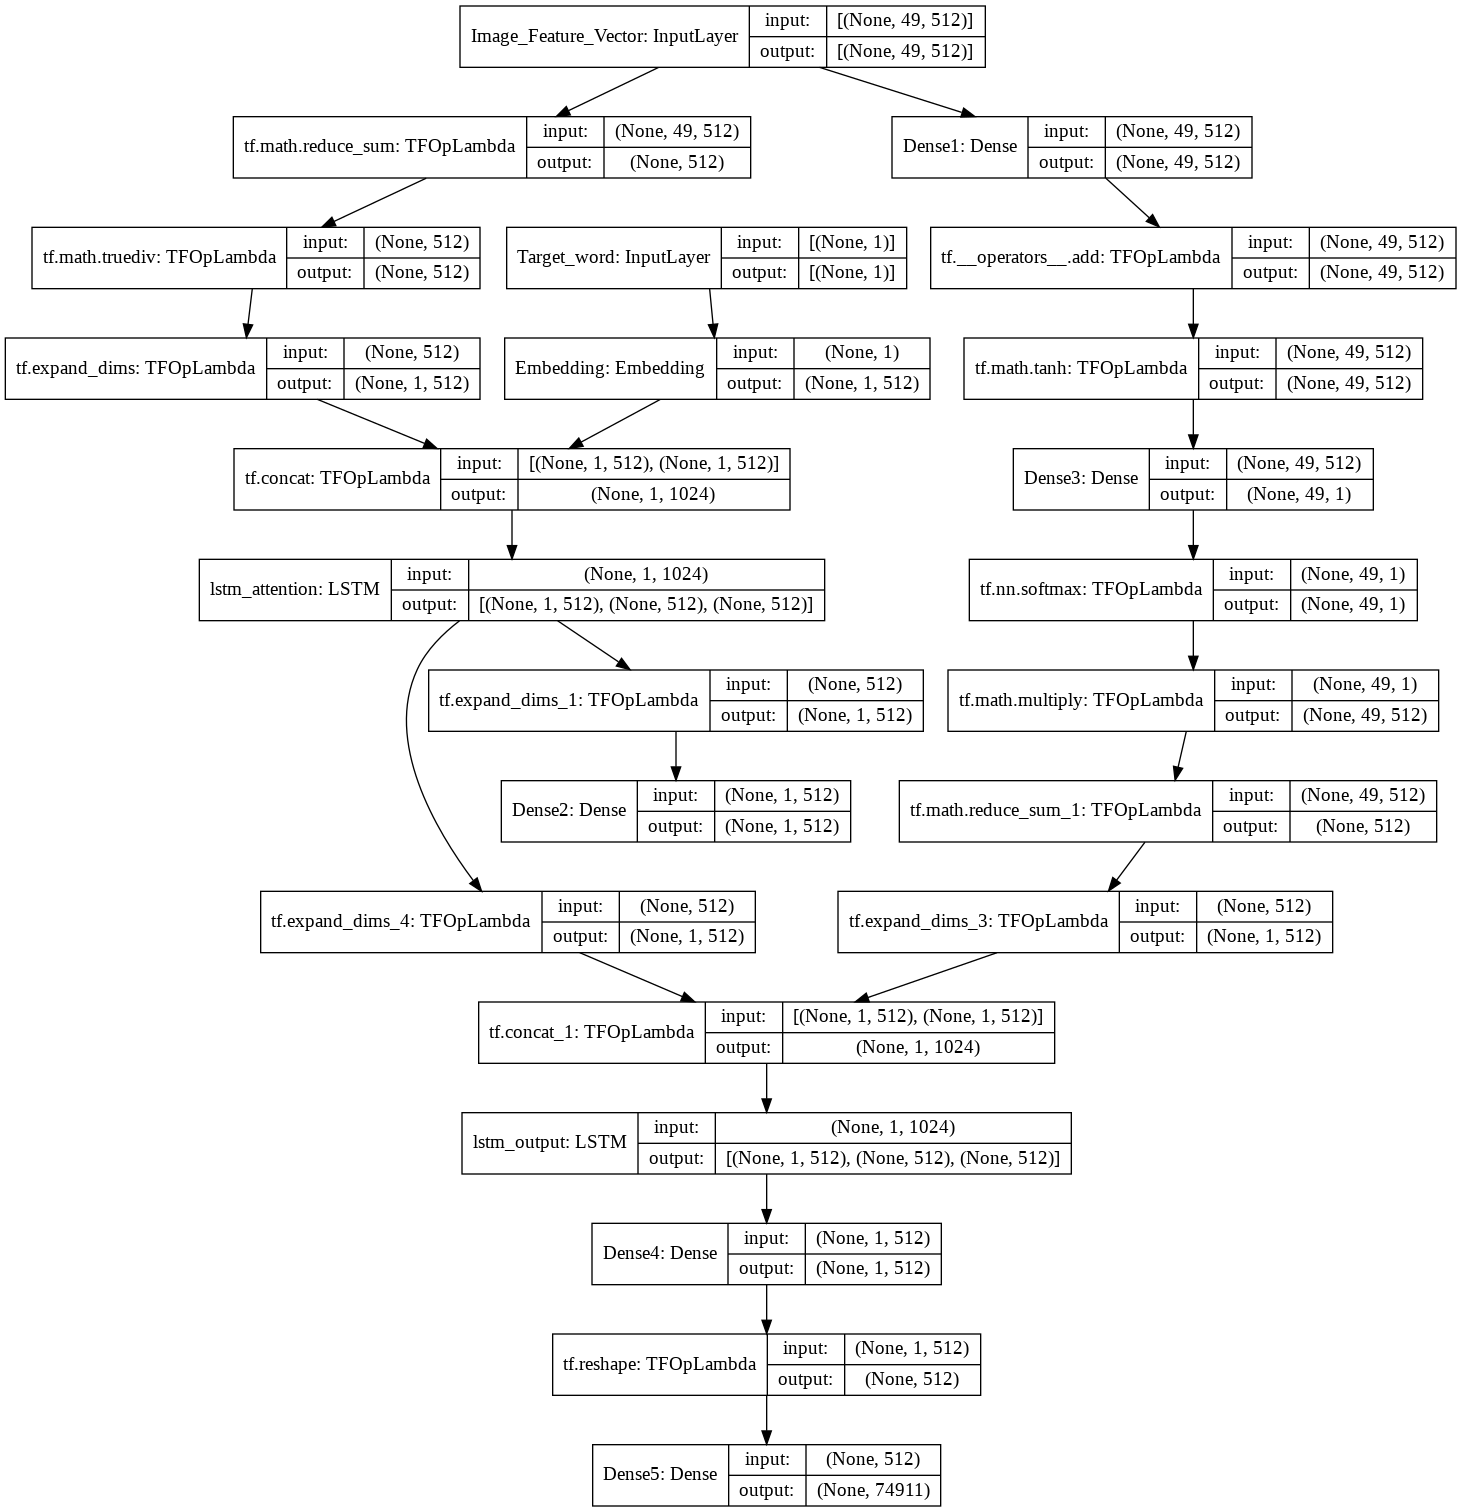

In [40]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Model Training

In [41]:
import keras.backend as KB
def my_metric(real, pred):
    return KB.sum(abs(real-pred))

In [42]:
loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction='none')
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_object,metrics=['accuracy'])

In [ ]:
history = model.fit(training_generator,validation_data=validation_generator, epochs=5,verbose=1 )

Epoch 1/5
8855/8855 [==============================] - 5245s 592ms/step - loss: 3.3115 - accuracy: 0.4784 - val_loss: 4.1560 - val_accuracy: 0.4608
Epoch 2/5
8855/8855 [==============================] - 5065s 572ms/step - loss: 2.7627 - accuracy: 0.5294 - val_loss: 4.0094 - val_accuracy: 0.4699
Epoch 3/5
8855/8855 [==============================] - 4806s 543ms/step - loss: 2.6194 - accuracy: 0.5413 - val_loss: 3.9314 - val_accuracy: 0.4765
Epoch 4/5
8855/8855 [==============================] - 4871s 550ms/step - loss: 2.5428 - accuracy: 0.5473 - val_loss: 3.8923 - val_accuracy: 0.4756
Epoch 5/5
8855/8855 [==============================] - 4844s 547ms/step - loss: 2.4917 - accuracy: 0.5509 - val_loss: 3.8972 - val_accuracy: 0.4779


In [ ]:
model.save('/content/drive/My Drive/model_VGG19.h5')

In [ ]:
# Save the model
model.save_weights('/content/drive/My Drive/wegihts_15464.h5')

In [ ]:
# Recreate the exact same model purely from the file
model.load_weights('Your_Path')

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/model_inception_res.h5')


In [ ]:
history = new_model.fit(training_generator, validation_data=validation_generator, epochs=6, verbose=1)

## Model Evaluation 

In [ ]:
def evaluate(image):
    #attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    img,image_path= load_image(image)
    img =np.expand_dims(img, axis=0)
    img_tensor_val = image_features_extract_model(img)
    img_tensor_val = tf.reshape(img_tensor_val,
                              (img_tensor_val.shape[0]*img_tensor_val.shape[1]*img_tensor_val.shape[2], img_tensor_val.shape[3]))
    img_tensor_val = pad_up_to(img_tensor_val, [num_boxes, features_shape], 0)
    img_tensor_val = tf.reshape(img_tensor_val, (-1, img_tensor_val.shape[0], img_tensor_val.shape[1]))

    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        #print(dec_input)
        #predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predictions = model.predict([img_tensor_val, dec_input], verbose=0)
         
        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = np.argmax(predictions)
        
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    return result

In [ ]:
def evaluate_with_beam_search(image, beam_width):
  
    img,image_path= load_image(image)
    img =np.expand_dims(img, axis=0)
    img_tensor_val = image_features_extract_model(img)
    img_tensor_val = tf.reshape(img_tensor_val,
                              (img_tensor_val.shape[0]*img_tensor_val.shape[1]*img_tensor_val.shape[2], img_tensor_val.shape[3]))
    img_tensor_val = pad_up_to(img_tensor_val, [num_boxes, features_shape], 0)
    img_tensor_val = tf.reshape(img_tensor_val, (-1, img_tensor_val.shape[0], img_tensor_val.shape[1]))
    features = img_tensor_val
    beam_list = [[[tokenizer.word_index['<start>']],0.0]]
    
    
    for i in range(max_length):
      new_beam_list= [] # This will have the maximum length of beam_width*beam_width
      
      for beam in beam_list:
        sequence, log_prob = beam
        
        if tokenizer.index_word[sequence[-1]] == '<end>': # Don't apply beam search after the end token has reached
          new_beam_list.append(beam)
        else:
          dec_input = tf.expand_dims([sequence[-1]], 0)
          predictions = model.predict([img_tensor_val, dec_input], verbose=0)    
          predictions = tf.math.log(tf.nn.softmax(predictions))
          top_predictions = np.argsort(predictions[0])[-beam_width:]
          for pid in top_predictions:
            log_prob_new = log_prob + predictions[0][pid]
            new_list = sequence + [pid]
            new_beam_list.append([new_list, log_prob_new])
        
      sorted_beams = sorted(new_beam_list, reverse=False, key=lambda l: l[1])
       
      beam_list = sorted_beams[-beam_width:]
        
    
    final_ids = beam_list[-1][0]
    
    result = [tokenizer.index_word[w_id] for w_id in final_ids]
    
    
    return result[0:]

In [ ]:
image = "joe.jpg"
img,image_path= load_image(image)
img =np.expand_dims(img, axis=0)
img_tensor_val = image_features_extract_model(img)
img_tensor_val = tf.reshape(img_tensor_val,
                              (img_tensor_val.shape[0]*img_tensor_val.shape[1]*img_tensor_val.shape[2], img_tensor_val.shape[3]))
img_tensor_val = pad_up_to(img_tensor_val, [num_boxes, features_shape], 0)
img_tensor_val = tf.reshape(img_tensor_val, (-1, img_tensor_val.shape[0], img_tensor_val.shape[1]))

    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

features = img_tensor_val

dec_input = tf.expand_dims([word_index['<start>']], 0)
result = []

for i in range(max_length):
    #print(dec_input)
    predictions = model.predict([img_tensor_val, dec_input], verbose=0)
        
        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
    predicted_id = tf.argmax(predictions[0]).numpy()
        
    print(index_word[predicted_id])

    if index_word[predicted_id] == '<end>':
         print(result)

    dec_input = tf.expand_dims([predicted_id], 0)


In [ ]:
dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
predictions = model.predict([img_tensor_val, dec_input])
predicted_id = tf.argmax(predictions[0]).numpy()
predicted_id
#print(tokenizer.index_word[predicted_id])

In [ ]:
def pad_up_to(t, max_in_dims, constant_values):
    s = tf.shape(t)
    paddings = [[0, m-s[i]] for (i,m) in enumerate(max_in_dims)]
    return tf.pad(t, paddings, 'CONSTANT', constant_values=constant_values)

Prediction Caption: 'دراجة نارية متوقفة في موقف للسيارات ' <end>
beam_search Caption: <start> 'دراجة نارية ' <end>


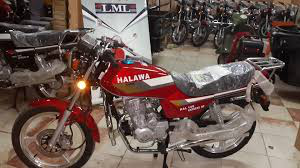

In [ ]:
#test your image 

image_path = '/content/16.jfif'

result = evaluate(image_path)
result2 = evaluate_with_beam_search(image_path,3)
print ('Prediction Caption:', ' '.join(result))
print ('beam_search Caption:', ' '.join(result2))
# opening the image
Image.open(image_path)

Real Caption: <start> أصفر السيارات النيون في 'فتاة السطح ' <end>
Prediction Caption Beam Search: <start> 'رجل يركب الزلاجات ' <end>
Prediction Caption Greedy: 'رجل يرتدي سترة زرقاء ' <end>


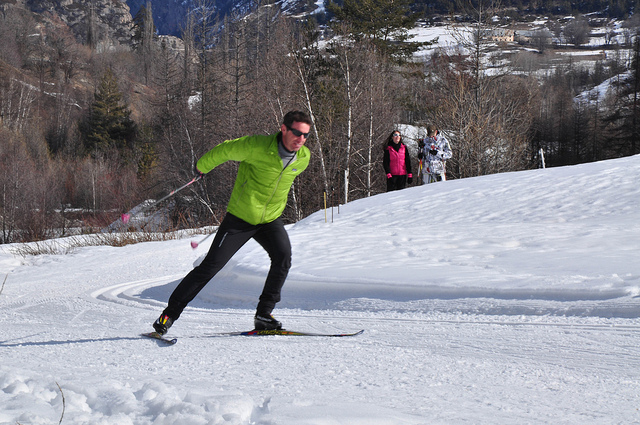

In [ ]:
rid = np.random.randint(0, len(img_name_vector_val))
image = img_name_vector_val[rid]
real_caption = ' '.join([tokenizer_val.index_word[i] for i in cap_vector_val[rid] if i not in [0]])
result = evaluate_with_beam_search(image, 3)
result_eval = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption Beam Search:', ' '.join(result))
print ('Prediction Caption Greedy:', ' '.join(result_eval))
#plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_vector_val[rid])

In [ ]:
val_image_to_captions = {}

for j, image_name in enumerate(img_name_vector):
  if image_name not in val_image_to_captions:
    val_image_to_captions[image_name] = [[tokenizer.index_word[i] for i in cap_vector[j] if i not in [0]]]
  else:
    val_image_to_captions[image_name].append([tokenizer.index_word[i] for i in cap_vector[j] if i not in [0]])
    
bleu_score = 0
for i, image in enumerate(val_image_to_captions):
  result = evaluate_with_beam_search(image,3)
  caption_bleu = nltk.translate.bleu_score.sentence_bleu(val_image_to_captions[image], result)
  if i%100 == 0:
    print("Processed {} number of images".format(i+1))
  bleu_score += caption_bleu
  
print("The average bleu score of the captions is {}".format(bleu_score/len(val_image_to_captions)))

In [ ]:
bleu_score/27701

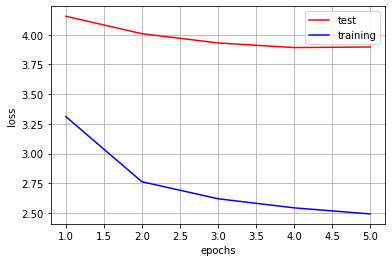

In [ ]:
loss_train = model.history.history['loss']
loss_test = model.history.history['val_loss']
epochs = model.history.params['epochs']
epochs = range(1, epochs+1)

plt.plot(epochs, loss_test, 'r', label='test')
plt.plot(epochs, loss_train, 'b', label='training')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig("model_loss.png", dpi=200)
plt.show()

In [ ]:
def predict_caption(model, images_features, tokenizer, maxlen):
    in_txt = '<START>'
    for word in range(max_length):
        seq = tokenizer.texts_to_sequences([in_txt])[0]
        seq = keras.preprocessing.sequence.pad_sequences([seq], maxlen=max_length)
        pred = model.predict([images_features, seq], verbose=0)
        pred = np.argmax(pred)
        new_word = index_word[pred]
        in_txt += ' ' + new_word
        if new_word == '<END>':
            #print('I saw END at index',word)
            break
    return in_txt

In [ ]:
def pad_up_to(t, max_in_dims, constant_values):
    s = tf.shape(t)
    paddings = [[0, m-s[i]] for (i,m) in enumerate(max_in_dims)]
    return tf.pad(t, paddings, 'CONSTANT', constant_values=constant_values)

In [ ]:
def pkl_gen(path):
    img,image_path= load_image(path)
    img =np.expand_dims(img, axis=0)
    img_tensor_val = image_features_extract_model(img)
    img_tensor_val = tf.reshape(img_tensor_val,
                              (img_tensor_val.shape[0]*img_tensor_val.shape[1]*img_tensor_val.shape[2], img_tensor_val.shape[3]))
    img_tensor_val = pad_up_to(img_tensor_val, [num_boxes, features_shape], 0)
    img_tensor_val = tf.reshape(img_tensor_val, (-1, img_tensor_val.shape[0], img_tensor_val.shape[1]))
    return img_tensor_val

In [ ]:
subset = {k:captions[k] for k in list(captions.keys())[-10:]}
pred = {}
for k,v in subset.items():
    cpt = predict_caption(seq2seq, features[k], tokenizer, max_len)
    pred[k] = [cpt]
visualize_images_with_captions(pred)

In [ ]:
features = pkl_gen('/content/COCO_train2014_000000078106.jpg')
cpt = predict_caption(seq2seq, features, tokenizer, 15)
cpt

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction='none')
model.compile(optimizer=optimizer, loss = loss_object,metrics=['accuracy'])


In [ ]:
model.fit(training_generator, epochs=25, verbose=1)

In [ ]:
x = model.predict(validation_generator)


In [ ]:
tf.argmax(x[0]).numpy()